In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("tab10", 8))
%config Completer.use_jedi = False

In [70]:
def simulate_dice_throws(dice_n_faces=6, max_n_simultaneous_throws=6, n_simulations = 1000000):
    
    '''
    Simulates dice throws.
    
    Param:
        - dice_n_faces: if it's a int, assume number indicates dice faces from 1 to dice_n_faces. 
    If it's a list, it indicates the values of the different faces
    
    '''
    if isinstance(dice_n_faces,list):
        simulated_throws= np.random.choice(dice_n_faces, size=(n_simulations,max_n_simultaneous_throws), replace=True)
    else:
        simulated_throws = np.random.randint(low = 1, high = dice_n_faces+1, 
                                                 size=(n_simulations,max_n_simultaneous_throws))
    
    throws = pd.DataFrame(simulated_throws)

    return throws

def prob_at_least_1_higher_than(throws, 
                                dice_n_faces=6, 
                                max_n_simultaneous_throws=6,                               
                                greater = False,
                               plot_it = False):
    '''
    Given a series of dice throws with varying number of simultaneous throws, the function estimates probability 
    that at least 1 die has value >= than a given threshold. Each die has dice_n_faces, with values going from 1 to dice_n_faces.
    
    - If greater = True, then it estimates probability that value > given threshold
    
    '''
    n_simulations = len(throws)
    my_probs ={}
    final_results = pd.DataFrame()
    aggregated_results = []
    empty_col = np.full((n_simulations, 1), False)

    if isinstance(dice_n_faces, list):
        max_threshold = max(dice_n_faces)+1
        dice_des = 'custom d' + str(len(dice_n_faces)) + ' with values ' + str(dice_n_faces)
    else:
        max_threshold = dice_n_faces+1
        dice_des = 'regular d'+ str(dice_n_faces)
        
    for i_n_simultaneous_throws in np.arange(1,max_n_simultaneous_throws+1):
        for i_threshold in np.arange(1,max_threshold):
            temp_results = {}

            if greater:
                tt = throws > i_threshold
                my_cond = '>'
            else:
                tt = throws >= i_threshold
                my_cond = '>='
                
            tt['results'] = empty_col

            for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
                tt['results'] = tt[i_throw_n] | tt['results']

            my_prob = sum(tt['results'])/len(tt['results'])

            temp_results['dice_n'] = i_n_simultaneous_throws
            temp_results['i_threshold'] = i_threshold
            temp_results['prob'] = my_prob

            aggregated_results.append(temp_results)
            
    results_df = pd.DataFrame(aggregated_results)
    
    if plot_it:
        ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
        plt.grid()
        plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
        plot_title = 'P of rolling at least 1 die ' + my_cond +' i_threshold, depending on n dice rolled'
        plot_title = plot_title + '\n(using '+ dice_des +')'
        plt.title(plot_title)
        
    return results_df

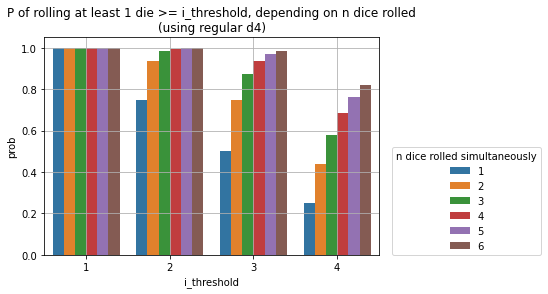

In [63]:
dice_n_faces=4
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws,  
                                         plot_it = True)


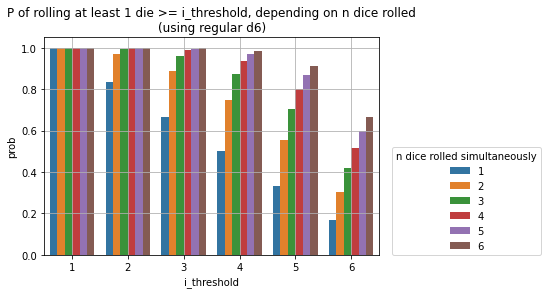

In [64]:
dice_n_faces=6
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws,  
                                         plot_it = True)


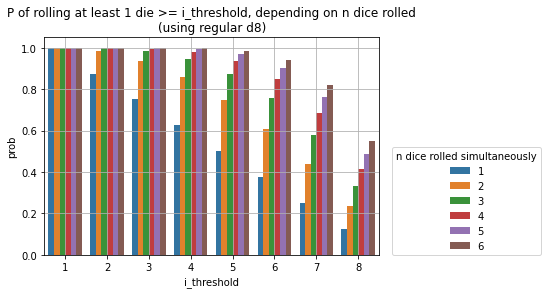

In [68]:
dice_n_faces=8
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws,  
                                         plot_it = True)

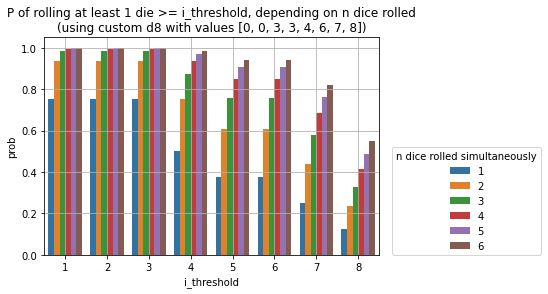

In [71]:
dice_n_faces=[0,0,3,3,4,6,7,8]
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws,  
                                         plot_it = True)

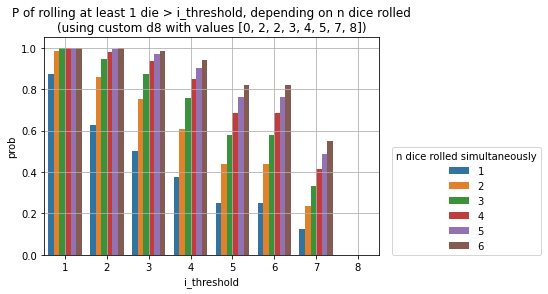

In [79]:
dice_n_faces=[0,2,2,3,4,5,7,8]
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws,  
                                         plot_it = True,
                                        greater = True)

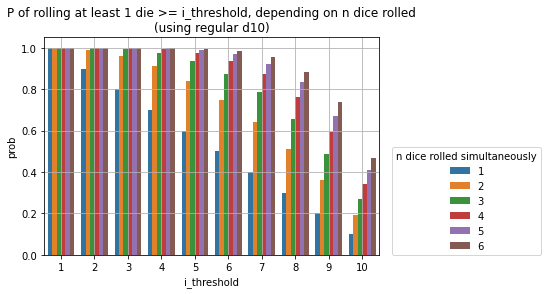

In [73]:
dice_n_faces=10
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws,
                                        plot_it = True)


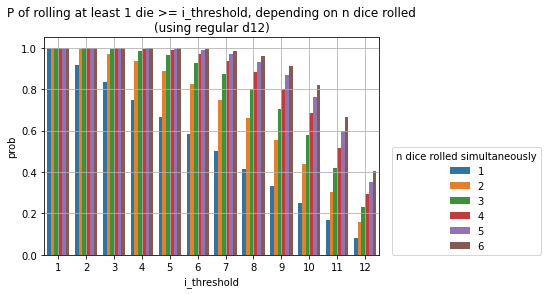

In [74]:
dice_n_faces=12
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws, 
                                        plot_it = True)


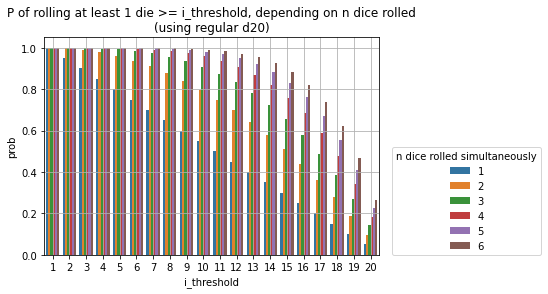

In [75]:
dice_n_faces=20
max_n_simultaneous_throws = 6

throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_1_higher_than(throws, 
                                         dice_n_faces=dice_n_faces, 
                                         max_n_simultaneous_throws=max_n_simultaneous_throws, 
                                        plot_it = True)
